Goal of this notebook: load renewable profiles AND AE data and merge them into one data object

Renewables data:

- solar
    - distributed
    - utility
- wind
    - onshore
    - offshore

variables on timelines:
- cf
- gen


variables on GWLs:
- drought mask

In [131]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from climakitae.core.data_interface import (
    get_data,
)

In [125]:
ae_wrf_sims = [
    "WRF_CESM2_r11i1p1f1",
    "WRF_MIROC6_r1i1p1f1",
    "WRF_CNRM-ESM2-1_r1i1p1f2",
    "WRF_EC-Earth3_r1i1p1f1",
    "WRF_TaiESM1_r1i1p1f1",
    "WRF_MPI-ESM1-2-HR_r3i1p1f1",
    "WRF_EC-Earth3-Veg_r1i1p1f1",
    "WRF_FGOALS-g3_r1i1p1f1",
]


ren_sims = ["ec-earth3", "mpi-esm1-2-hr", "miroc6", "taiesm1"]

sim_name_dict = {
    "ec-earth3": "WRF_EC-Earth3_r1i1p1f1",
    "mpi-esm1-2-hr": "WRF_MPI-ESM1-2-HR_r3i1p1f1",
    "miroc6": "WRF_MIROC6_r1i1p1f1",
    "taiesm1": "WRF_TaiESM1_r1i1p1f1",
}

sim_gwl_name_dict = {
    "ec-earth3": "WRF_EC-Earth3_r1i1p1f1_historical+ssp370",
    "mpi-esm1-2-hr": "WRF_MPI-ESM1-2-HR_r3i1p1f1_historical+ssp370",
    "miroc6": "WRF_MIROC6_r1i1p1f1_historical+ssp370",
    "taiesm1": "WRF_TaiESM1_r1i1p1f1_historical+ssp370",
}

scenario_dict = {
    "historical": "Historical Climate",
    "ssp3-7.0": "SSP 3-7.0",
    "reanalysis": "Historical Reconstruction",
}
resolution_dict = {"d03": "3 km", "d02": "9 km"}

frequency_dict = {"day", "daily", "1hr", "hourly"}


gwl_name_dict = {
    "plus08c": 0.8,
    "plus10c": 1.0,
    "plus12c": 1.2,
    "plus15c": 1.5,
    "plus20c": 2.0,
    "plus25c": 2.5,
    "plus30c": 3.0,
    "plus40c": 4.0,
}

In [ ]:
# simulation = 'era5'
# scenario = 'reanalysis'

# simulations= ["ec-earth3", "mpi-esm1-2-hr", "miroc6", "taiesm1"]
# scenarios = ["historical", 'ssp370']

In [120]:
def get_ren_cf_data(resource, module, domain, variable, frequency, simulation):
    path = f"s3://wfclimres/era/{resource}_{module}/{simulation}/{scenario}/{frequency}/{variable}/{domain}/"
    ds = xr.open_zarr(path, storage_options={"anon": True})
    return ds


def get_ren_drought_data(
    resource, module, domain, variable, frequency, simulation, gwl
):
    path = f"s3://wfclimres/era/resource_drought/{resource}/{resource}_{module}/{simulation}/{gwl}/{frequency}/{variable}/{domain}"
    ds = xr.open_zarr(path, storage_options={"anon": True})
    return ds

In [ ]:
# loading renewables and WRF data in timeseries

resource = "pv"
module = "utility"
domain = "d03"
variable = "cf"
frequency = "day"
simulation = "all"
simulation = "ec-earth3"
scenario = "historical"

wrf_var = "Precipitation (total)"


# Gen renewables CF data
print(f"Loading {simulation} {scenario} data...")

ds = get_ren_cf_data(resource, module, domain, variable, frequency, simulation)
ren_cf = ds["cf"]
ren_cf = ren_cf.isel(
    x=slice(10, -10), y=slice(10, -10)
)  # trim the edges to match the WRF AE domain (check this for d03)

# get WRF data
wrf_simulation = sim_name_dict[simulation]
wrf_scenario = scenario_dict[scenario]
wrf_resolution = resolution_dict[domain]
wrfdat = get_data(
    variable=wrf_var,
    downscaling_method="Dynamical",
    resolution=wrf_resolution,
    timescale="daily",
    scenario=wrf_scenario,
)
wrfdat = wrfdat.sel(simulation=wrf_simulation)


# crop the time axis of the WRF data to match the ren data
start_time = ren_cf.time.values[0]
end_time = ren_cf.time.values[-1]
wrfdat = wrfdat.sel(time=slice(start_time, end_time))

combined_ds = xr.merge([wrfdat, ren_cf])
combined_ds = combined_ds.squeeze()

Loading ec-earth3 historical data...


/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/climakitae/core/data_load.py:548: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  all_hist = xr.concat(


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_67239/2297675740.py:47: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  combined_ds = xr.merge([wrfdat, ren_cf])
/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_67239/2297675740.py:47: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  combined_ds = xr.merge([wrfdat, ren_c

In [115]:
combined_ds

<xarray.Dataset> Size: 10GB
Dimensions:                (time: 12054, x: 223, y: 472)
Coordinates:
  * time                   (time) datetime64[ns] 96kB 1980-12-31 ... 2013-12-31
  * x                      (x) float64 2kB -4.305e+06 -4.302e+06 ... -3.639e+06
  * y                      (y) float64 4kB 4.849e+05 4.879e+05 ... 1.898e+06
    simulation             <U26 104B 'WRF_EC-Earth3_r1i1p1f1'
    Lambert_Conformal      int32 4B 1
    lakemask               (y, x) float32 421kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    landmask               (y, x) float32 421kB dask.array<chunksize=(77, 32), meta=np.ndarray>
    lat                    (y, x) float32 421kB dask.array<chunksize=(77, 32), meta=np.ndarray>
    lon                    (y, x) float32 421kB dask.array<chunksize=(77, 32), meta=np.ndarray>
    scenario               <U18 72B 'Historical Climate'
Data variables:
    Precipitation (total)  (time, y, x) float32 5GB dask.array<chunksize=(1651, 77, 32), meta=np.ndarray>
    cf                     (y, x, time) float32 5GB dask.array<chunksize=(77, 32, 9143), meta=np.ndarray>
Attributes:
    variable_id:           prec
    extended_description:  Total precipitation. Computed by summing total gri...
    units:                 mm
    data_type:             Gridded
    resolution:            3 km
    frequency:             daily
    location_subset:       ['entire domain']
    approach:              Time
    downscaling_method:    Dynamical
    institution:           UCLA
    grid_mapping:          Lambert_Conformal

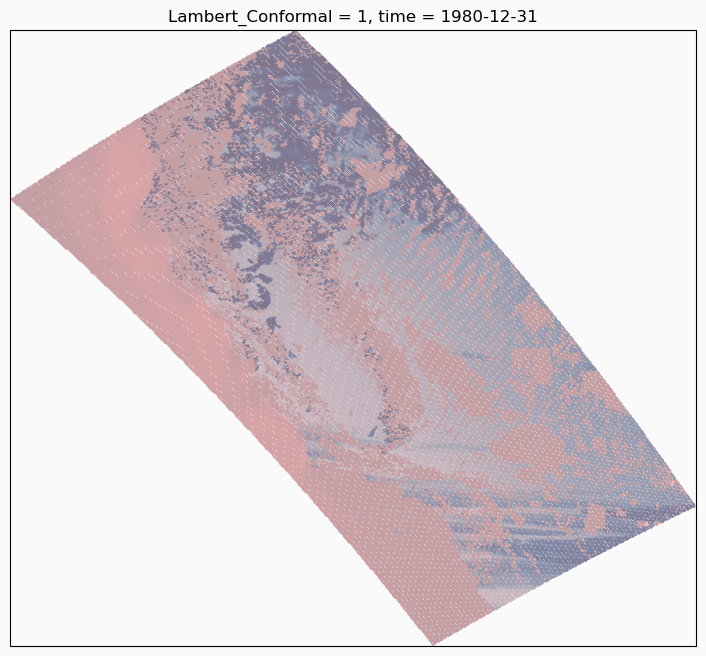

In [92]:
fig = plt.figure(figsize=(10, 8), facecolor="#FAFAFA")  # open matplotlib figure

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_facecolor("#FAFAFA")

im = wrfdat.isel(time=0).plot(
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    ax=ax,
    zorder=3,
    alpha=0.2,
    add_colorbar=False,
    cmap="Reds_r",
)

im = ren_cf.isel(time=0).plot(
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    ax=ax,
    zorder=3,
    alpha=0.2,
    add_colorbar=False,
    cmap="Blues_r",
)

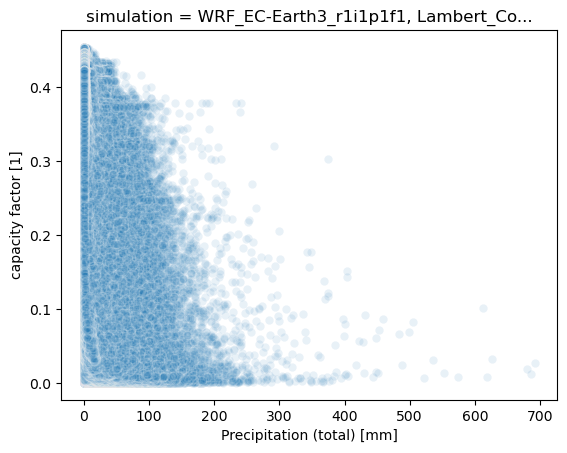

In [ ]:
combined_ds.isel(time=slice(0, 1000)).plot.scatter(
    x="Precipitation (total)", y="cf", alpha=0.1
)

In [ ]:
## WIP - loading drought data on GWLs
resource = "pv"
module = "utility"
domain = "d02"

frequency = "day"
simulation = "all"
simulation = "ec-earth3"
scenario = "historical"

gwl = "plus08c"

wrf_var = "Precipitation (total)"


variable = "drought_mask"

# Gen renewables CF data
print(f"Loading {simulation} {scenario} data...")

ds = get_ren_drought_data(
    resource, module, domain, variable, frequency, simulation, gwl
)
ren_cf = ds["drought_mask"]
ren_cf = ren_cf.isel(
    x=slice(10, -10), y=slice(10, -10)
)  # trim the edges to match the WRF AE domain (check this for d03)

# get WRF data
wrf_simulation = sim_gwl_name_dict[simulation]
wrf_scenario = scenario_dict[scenario]
wrf_resolution = resolution_dict[domain]

wrfdat = get_data(
    variable=wrf_var,
    downscaling_method="Dynamical",
    resolution=wrf_resolution,
    timescale="daily",
    scenario=wrf_scenario,
    approach="Warming Level",
    warming_level=gwl_name_dict[gwl],
)
wrfdat = wrfdat.sel(simulation=wrf_simulation)

# crop the time axis of the WRF data to match the ren data
start_time = ren_cf.time.values[0]
end_time = ren_cf.time.values[-1]
wrfdat = wrfdat.sel(time=slice(start_time, end_time))

combined_ds = xr.merge([wrfdat, ren_cf])
combined_ds = combined_ds.squeeze()

Loading ec-earth3 historical data...


/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/climakitae/core/data_load.py:548: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  all_hist = xr.concat(
/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/climakitae/core/data_load.py:589: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  one_scenario = xr.concat

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



KeyError: "not all values found in index 'simulation'. Try setting the `method` keyword argument (example: method='nearest')."

In [127]:
wrf_simulation = sim_gwl_name_dict[simulation]

wrfdat = wrfdat.sel(simulation=wrf_simulation)

In [130]:
ren_cf.time.values

array(['1988-01-01T00:00:00.000000000', '1988-01-02T00:00:00.000000000',
       '1988-01-03T00:00:00.000000000', ...,
       '2017-12-29T00:00:00.000000000', '2017-12-30T00:00:00.000000000',
       '2017-12-31T00:00:00.000000000'],
      shape=(10585,), dtype='datetime64[ns]')

In [128]:
wrfdat

<xarray.DataArray np.str_('Precipitation (total)') (warming_level: 1,
                                                    time_delta: 10950, y: 320,
                                                    x: 250)> Size: 4GB
dask.array<getitem, shape=(1, 10950, 320, 250), dtype=float32, chunksize=(1, 317, 40, 33), chunktype=numpy.ndarray>
Coordinates:
  * warming_level      (warming_level) float64 8B 0.8
  * x                  (x) float64 2kB -4.638e+06 -4.629e+06 ... -2.397e+06
  * y                  (y) float64 3kB -2.441e+05 -2.351e+05 ... 2.627e+06
  * time_delta         (time_delta) float64 88kB -5.475e+03 ... 5.474e+03
    Lambert_Conformal  int32 4B 1
    lakemask           (y, x) float32 320kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    landmask           (y, x) float32 320kB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 320kB 23.35 23.39 23.43 ... 56.42 56.46
    lon                (y, x) float32 320kB -116.5 -116.4 ... -111.6 -111.5
    centered_year      int64 8B 2003
    simulation         <U44 176B 'WRF_EC-Earth3_r1i1p1f1_historical+ssp370'
Attributes:
    variable_id:           prec
    extended_description:  Total precipitation. Computed by summing total gri...
    units:                 mm
    data_type:             Gridded
    resolution:            9 km
    frequency:             daily
    location_subset:       ['entire domain']
    approach:              Warming Level
    downscaling_method:    Dynamical
    warming_level_window:  +/- 15 years from centered year
    institution:           UCLA
    grid_mapping:          Lambert_Conformal